<h1> Trabalho Biomecânica - Theo Pavan </h1>
<h3> ------------------------------------------------ </h3>

Função para mostrar imagens (plot)

In [ ]:
from matplotlib import pyplot as plt

def showSingleImage(img, title, size, slice_index=74):
    fig, axis = plt.subplots(figsize=size)
    if img.ndim == 3:
        axis.imshow(img[:, :, slice_index], cmap='gray')
    else:
        axis.imshow(img, cmap='gray')
    axis.set_title(title, fontdict={'fontsize': 22, 'fontweight': 'medium'})
    plt.show()
def showMultipleImages(imgsArray, titlesArray, size, x, y, slice_index=74):
    if(x < 1 or y < 1):
        print("ERRO: X e Y não podem ser zero ou abaixo de zero!")
        return
    elif(x == 1 and y == 1):
        showSingleImage(imgsArray[0], titlesArray[0], size, slice_index)
    else:
        fig, axes = plt.subplots(y, x, figsize=size)
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
        for i, (img, title) in enumerate(zip(imgsArray, titlesArray)):
            if i < len(axes):
                if img.ndim == 3:
                    axes[i].imshow(img[:, :, slice_index], cmap='gray')
                else:
                    axes[i].imshow(img, cmap='gray')
                axes[i].set_title(title, fontdict={'fontsize': 18, 'fontweight': 'medium'}, pad=10)
                axes[i].set_anchor('NW')
            else:
                break
    plt.tight_layout()
    plt.show()

'''def writeMultipleImages(imgsArray, titlesArray, name):
    index = 0
    for img, title in zip(imgsArray, titlesArray):
        index += 1
        cv2.imwrite(f'{name}_{index}_{title}.tif', img)'''

Função para ler arquivo (.mat / xlsx)

In [16]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def ler(imgs, slice_index=74):
    print("ler() function called with slice_index:", slice_index)
    disp_maps = []
    for img in imgs:
        mat_data = scipy.io.loadmat(img)
        disp_map = mat_data['disp_map']
        disp_maps.append(disp_map)
    
    showMultipleImages(disp_maps, imgs, (12, 8), 1, 3, slice_index)


def xlsx(arquivo):
    df = pd.read_excel(arquivo, engine='openpyxl')
    # print(df.head())
    return df

Função plot módulo de young

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress


def plotDataFrame(df):
    phantoms = {
        "P_1": (0, 1),  # Índices para P_1
        "P_2": (3, 4),  # Índices para P_2
        "P_3": (6, 7),  # Índices para P_3
    }

    # Dicionário para armazenar os módulos de Young
    modulos_young = {}
    
    # Create a single figure
    plt.figure(figsize=(10, 6))
    
    # Loop sobre cada phantom
    for nome, (c0, c1) in phantoms.items():
        strain = df.iloc[:, c0]
        stress = df.iloc[:, c1]

        # Converter para valores numéricos
        strain = pd.to_numeric(strain, errors='coerce')
        stress = pd.to_numeric(stress, errors='coerce')

        # Remover linhas com valores não numéricos
        df_plot = pd.DataFrame({'Strain': strain, 'Stress': stress}).dropna()

        # Realizar o ajuste linear
        slope, intercept, r_value, p_value, std_err = linregress(df_plot['Strain'], df_plot['Stress'])

        # O módulo de Young é dado pela inclinação do ajuste linear
        modulos_young[nome] = slope

        # Plotar os dados e o ajuste
        plt.plot(df_plot['Strain'], df_plot['Stress'], 'o', label=f'{nome} Dados')
        plt.plot(df_plot['Strain'], slope * df_plot['Strain'] + intercept, 
                label=f'{nome} Ajuste', linestyle='--')

    # Configurar o gráfico
    plt.xlabel('Strain')
    plt.ylabel('Stress')
    plt.title('Módulo de Young')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Exibir os módulos de Young calculados
    for nome, modulo in modulos_young.items():
        print(f'Módulo de Young para {nome}: {modulo:.2f} Pa')

    return modulos_young

Função calcular velocidade e módulo de young .mat

In [12]:
import scipy.io
import numpy as np


def calcular_velocidade_media(img_path, dist, densidade=900):
    mat_data = scipy.io.loadmat(img_path)
    disp_map = mat_data['disp_map']
    
    # Parâmetros
    taxa_amostragem = 10000  # frames por segundo
    dt = 1 / taxa_amostragem  # intervalo de tempo em segundos
    
    velocidades = []
    
    # Calcular a velocidade para cada coluna
    for col in range(disp_map.shape[1]):
        if disp_map.ndim == 3:
            t_peak = np.argmax(np.abs(disp_map[:, col, :])) * dt
        else:
            t_peak = np.argmax(np.abs(disp_map[:, col])) * dt
        
        if t_peak > 0:
            velocidade = dist / t_peak
            velocidades.append(velocidade)

    if not velocidades:
        return None, None, None

    # Calcular a velocidade média
    velocidade_media = np.mean(velocidades)
    
    # Calcular módulo de Young
    modulo_young = densidade * (velocidade_media ** 2)
    
    # Calcular módulo de cisalhamento
    modulo_cisalhamento = modulo_young / 3
    
    return velocidade_media, modulo_cisalhamento, modulo_young

Função para gerar Graficos

In [18]:
def plot_resultados(imgs, resultados):
    # Extrair apenas o nome do phantom do caminho completo do arquivo
    phantoms = []
    for img in imgs:
        nome = img.split('/')[-1]  # Pega o último elemento após dividir pelo '/'
        nome = nome.split('\\')[-1]  # Pega o último elemento após dividir pelo '\'
        nome = nome.replace('SRF-SWE-Phantom_', '').replace('.mat', '')  # Remove prefixo e extensão
        phantoms.append(nome)

    # Separar os resultados em listas
    velocidades = []
    young_modulus = []
    for res in resultados:
        if res[0] is not None:  # Verifica se os resultados são válidos
            velocidades.append(res[0])
            young_modulus.append(res[2]/1000)  # Convertendo para kPa

    # Criar o plot apenas se houver dados válidos
    if velocidades and young_modulus:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Plot velocidades
        bars1 = ax1.bar(phantoms, velocidades)
        ax1.set_ylabel('Velocidade (m/s)')
        ax1.set_title('Velocidade Média de Cisalhamento')
        # Adicionar valores sobre as barras
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')
        
        # Plot módulo de Young
        bars2 = ax2.bar(phantoms, young_modulus)
        ax2.set_ylabel('Módulo de Young (kPa)')
        ax2.set_title('Módulo de Young')
        # Adicionar valores sobre as barras
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()
    else:
        print("Não há dados válidos para plotar")

<h3> MAIN </h3>

ler() function called with slice_index: 74


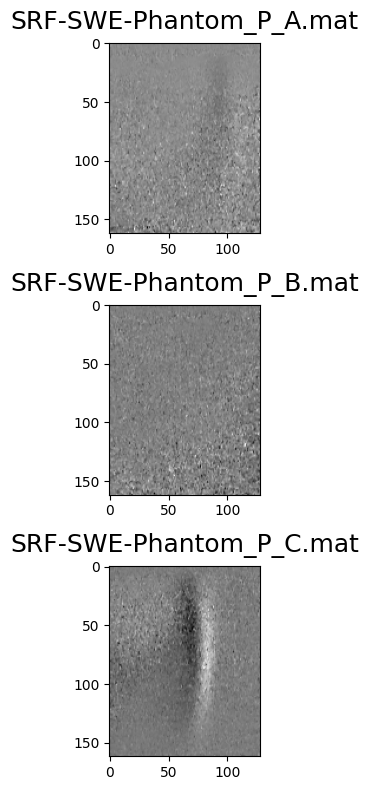

Resultados para SRF-SWE-Phantom_P_A.mat:
Velocidade média: 0.08 m/s
Módulo de cisalhamento: 1.79 Pa
Módulo de Young: 5.38 Pa

Resultados para SRF-SWE-Phantom_P_B.mat:
Velocidade média: 0.08 m/s
Módulo de cisalhamento: 1.79 Pa
Módulo de Young: 5.38 Pa

Resultados para SRF-SWE-Phantom_P_C.mat:
Velocidade média: 0.11 m/s
Módulo de cisalhamento: 3.76 Pa
Módulo de Young: 11.28 Pa



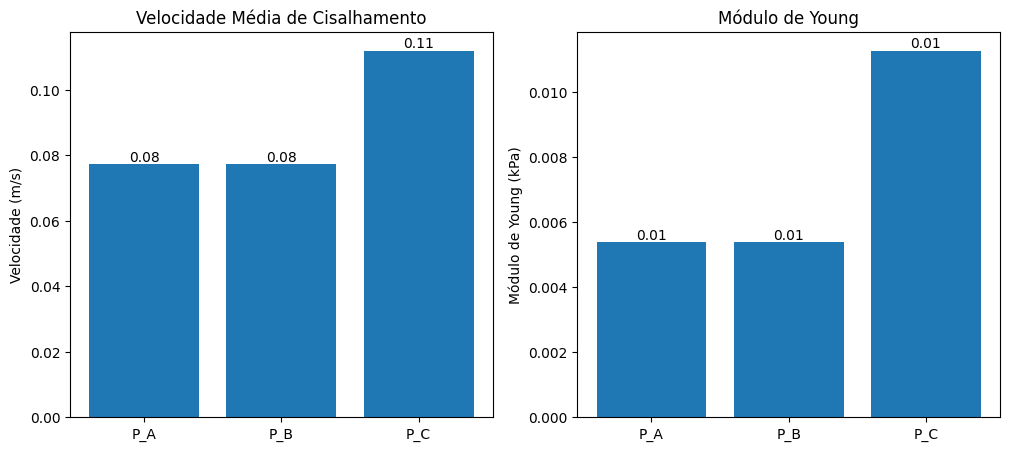

In [19]:
def imagens(imgs, slice_index=74):
    ler(imgs, slice_index)
    return None


# Main code
# Definir os caminhos das imagens
imgs = [
    'SRF-SWE-Phantom_P_A.mat',
    'SRF-SWE-Phantom_P_B.mat',
    'SRF-SWE-Phantom_P_C.mat'
]

# Exibir as imagens
imagens(imgs, slice_index=74)

# Calcular velocidades e módulos de Young
dist = 0.1  # distância em metros
densidade = 900  # densidade em kg/m³
resultados = []

for img in imgs:
    velocidade_media, modulo_cisalhamento, modulo_young = calcular_velocidade_media(img, dist, densidade)
    resultados.append((velocidade_media, modulo_cisalhamento, modulo_young))
    print(f"Resultados para {img}:")
    print(f"Velocidade média: {velocidade_media:.2f} m/s")
    print(f"Módulo de cisalhamento: {modulo_cisalhamento:.2f} Pa")
    print(f"Módulo de Young: {modulo_young:.2f} Pa")
    print()

# Plotar os resultados
plot_resultados(imgs, resultados)

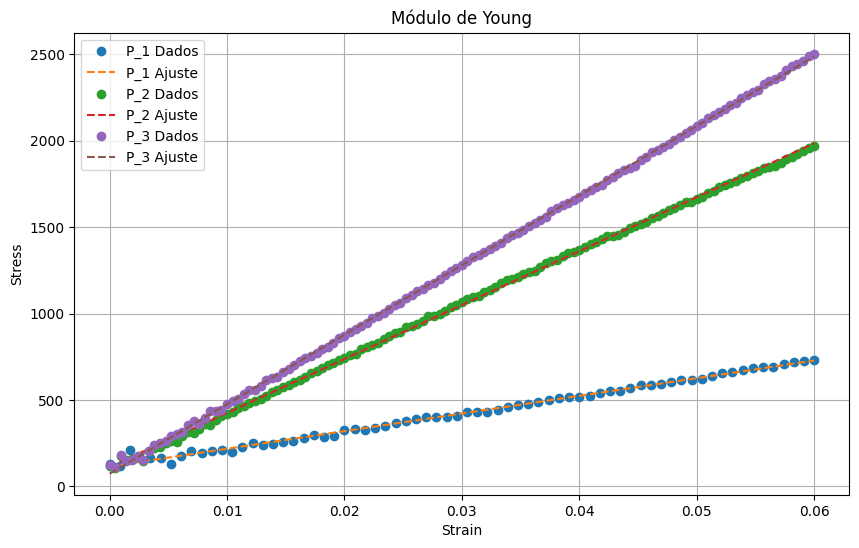

Módulo de Young para P_1: 10208.86 Pa
Módulo de Young para P_2: 31212.38 Pa
Módulo de Young para P_3: 40238.91 Pa


In [88]:
def planilha(pl):
    return pd.read_excel(pl, engine='openpyxl')

# Usage
pl = 'Tensão deformação.xlsx'
df = planilha(pl)
modulos = plotDataFrame(df)

In [27]:
import numpy as np
import scipy.io

# Parâmetros
dt = 0.0001  # Intervalo de tempo entre frames (s)
dx = 0.2977  # Resolução lateral (mm)
densidade = 900  # Densidade do material (kg/m³)

# Função para calcular a velocidade da onda de cisalhamento usando o tempo ao pico
def calcular_velocidade_onda_tempo_ao_pico(disp_map, dt, dx):
    num_frames = disp_map.shape[2]
    tempo_pico_por_coluna = np.zeros(disp_map.shape[1])

    for coluna in range(disp_map.shape[1]):
        deslocamento_temporal = disp_map[:, coluna, :]
        media_deslocamento_temporal = deslocamento_temporal.mean(axis=0)
        frame_pico = np.argmax(media_deslocamento_temporal)
        tempo_pico_por_coluna[coluna] = frame_pico * dt

    posicao_inicial = 0
    posicao_final = len(tempo_pico_por_coluna) - 1
    distancia_total = (posicao_final - posicao_inicial) * dx
    tempo_total = tempo_pico_por_coluna[posicao_final] - tempo_pico_por_coluna[posicao_inicial]
    velocidade_onda = distancia_total / tempo_total

    return velocidade_onda

# Função para calcular o módulo de Young a partir da velocidade da onda de cisalhamento
def calcular_modulo_de_young(velocidade_onda, densidade):
    velocidade_onda_m_s = velocidade_onda / 1000.0
    modulo_de_young = 3 * densidade * (velocidade_onda_m_s ** 2)
    return modulo_de_young

# Lista de caminhos para os arquivos dos phantoms
file_paths = [
    "SRF-SWE-Phantom_P_A.mat",
    "SRF-SWE-Phantom_P_B.mat",
    "SRF-SWE-Phantom_P_C.mat"
]

# Calcula e armazena os resultados para cada phantom
resultados = []

for file_path in file_paths:
    mat_data = scipy.io.loadmat(file_path)
    disp_map = mat_data['disp_map']

    velocidade_onda = calcular_velocidade_onda_tempo_ao_pico(disp_map, dt, dx)
    modulo_de_young = calcular_modulo_de_young(velocidade_onda, densidade)

    resultados.append({
        "file_path": file_path,
        "velocidade_onda": velocidade_onda,
        "modulo_de_young": modulo_de_young
    })

# Exibe os resultados
for i, resultado in enumerate(resultados, 1):
    print(f"Phantom {i}:")
    print(f"  Velocidade da onda de cisalhamento: {resultado['velocidade_onda']:.2f} mm/s")
    print(f"  Módulo de Young: {resultado['modulo_de_young']:.2f} Pa\n")


Phantom 1:
  Velocidade da onda de cisalhamento: 6098.05 mm/s
  Módulo de Young: 100402.72 Pa

Phantom 2:
  Velocidade da onda de cisalhamento: 9001.88 mm/s
  Módulo de Young: 218791.42 Pa

Phantom 3:
  Velocidade da onda de cisalhamento: 3706.66 mm/s
  Módulo de Young: 37096.12 Pa

